# Задание

### Определение доходности облигаций по данным ММВБ

*Disclaimer: данное задание подготовлено исключительно для тренировки навыков анализа данных, результаты выполнения задания не являются рекомендациями по операциям с облигациями, автор задания не является инвестиционным консультантом.
Имеются данные по облигациям, которые торгуются на ММВБ на текущую дату.*

Требуется выполнить следующие действия с данными по облигациям на дату формирования данных:
1. Оценить рынок рублевых облигаций по распределению купонной доходности, предложить разделение на кластеры по купонной доходности. 
Предложить графическое представление полученных групп/кластеров. (график)
2. По низкорисковым рублевым облигациям с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигациям выпущенным в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей дата. (график и/или таблица). 
3. Допускается обоснованное изменение условий как по критериям оценки рынка, так с учетом выбранной стратегии инвестирования.

Датасет с данными расположен по адресу: https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru
 
На усмотрение слушателя:
- можно скачать и загрузить в вашем скрипте файл csv  (например, pd.read_csv с указанием русской кодировки, релевантного знака сепарирования и номера строки заголовков),
- загружать on-line:
 s=requests.get(bond_url).content
pd.read_csv(io.StringIO(s.decode('УКАЗАТЬ КОДИРОВКУ')), sep='СЕПАПРАТОР', header=№ СТРОКИ ЗАГОЛОВКОВ)

Могут быть использованы следующие поля (а также все остальные) в любых комбинациях:  
'SECID' - Код ценной бумаги,   
'SHORTNAME' - Краткое наименование,   
'NAME' Полное наименование,   
'FACEVALUE' - Номинальная стоимость,    
'FACEUNIT' - валюта,   
'DURATION' - дюрация,   
'IS_QUALIFIED_INVESTORS' - признак продукта для квалифицированных инвесторов,   
'HIGH_RISK' - признак уровня риска,   
'COUPONFREQUENCY' – число купонов в год,   
'COUPONDATE' - Дата выплаты купона,   
'COUPONPERCENT' - Ставка купона, %,    
'COUPONVALUE' - Сумма купона, в валюте номинала,    
'OFFERDATE' - Дата оферты,    
'EMITENTNAME' – наименование эмитента,    
'INN' – ИНН эмитента,   
'PRICE' – текущий % от FACEVALUE,    
'PRICE_RUB' - котировка   
 
Пояснения:
1. Для получения текущей даты можно использовать метод  datetime.date.today();
2. Период расчета доходности рекомендуется выбирать 365 дней с текущей даты;
3. Нужно учитывать накопленный купонный доход (НКД) и разницу котировки и номинала ;
4. Расчет доходности можно посмотреть, например, [здесь](https://www.banki.ru/blog/BAY/10702.php).<br>
(Доход) = (Цена облигации при продаже) + (НКД на момент продажи)  
(Расходы) = (Цена облигации при покупке) + (НКД на момент покупки)+(Комиссии за приобретение, реализацию, хранение)  
Комиссии Сбера зависят от тарифа, объема сделок и пр. Подробнее см. [здесь](https://www.sberbank.ru/ru/person/investments/broker_service/tarifs).<br> 
В общем случае считаем налог доход при ставке НДФЛ 13% (при желании можно считать 15%) и комиссию брокера 0.06%.   
Комиссию Биржи принимаем в 0.0125%. 

\begin{equation} 
Profit =  \frac{((Цена_{номинальная} - Цена_{покупки}) * (1 ЕСЛИ <= 0 │ 0.87 ЕСЛИ > 0) – НКД + 0.87 * Купонный Доход_{руб} * X лет) * 100 %} {((Цена_{покупки} + НКД)*(1 + Комиссия Брокера в Процентах / 100 + Комиссия Биржи / 100))}
\end{equation}

5. Период расчета НКД:  df['COUPONDAYSPASSED']/df['COUPONLENGTH'] , рекомендуется выбирать меньше или равный  0.2.    
Если удовлетворяет условию, полученная величина умножается на COUPONPERCENT/COUPONFREQUENCY.
6. Датасет содержит данные, которые нужно преобразовывать в форматы python, а также пустые и искаженные данные, с которыми тоже нужно что-то решить.


## Библиотеки

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics as metrics
from sklearn.decomposition import PCA

In [58]:
# df = pd.read_csv('rates.csv', encoding='cp1251', sep=';', header=0)
# df.head()

## Загрузка данных

In [2]:
bond_url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'
s = requests.get(bond_url).content
df = pd.read_csv(io.StringIO(s.decode('cp1251')), sep=';', header=1)
df.head()

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED
0,AMUNIBB2AER2,UBANK11/22,UNIBANK OJSC Series 1,Корпоративные еврооблигации,AMUNIBB2AER2,NaN,3.0,"100,0",USD,10000.0,...,"0,0","11363,86","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
1,AMUNIBB2DER6,UBANK02/24,UNIBANK OJSC Series 1 21,Корпоративные еврооблигации,AMUNIBB2DER6,NaN,3.0,"100,0",USD,33478.0,...,"0,0","11526,94","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2,AT0000A2UF10,Raiff CAG,Raiffeisen Centrobank AG,Корпоративные еврооблигации,AT0000A2UF10,NaN,3.0,"1000,0",USD,50000.0,...,"0,0","94576,06","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
3,CH0248531110,VTB-24 CHF,VTB CAPITAL S.A. 24 CHF,Корпоративные еврооблигации,CH0248531110,NaN,NaN,"5000,0",CHF,70000.0,...,"0,0","604771,46","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
4,CH0374882816,GAZ-22 CHF,GAZ CAPITAL SA 2.25 19/07/22,Корпоративные еврооблигации,CH0374882816,NaN,NaN,"5000,0",CHF,100000.0,...,"184908,39","277362,59","14,0",2000.0,"17,0",10000.0,"20,0","14,00000","14,00000",1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2660 entries, 0 to 2659
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SECID                   2660 non-null   object 
 1   SHORTNAME               2660 non-null   object 
 2   NAME                    2660 non-null   object 
 3   TYPENAME                2660 non-null   object 
 4   ISIN                    2660 non-null   object 
 5   REGNUMBER               2266 non-null   object 
 6   LISTLEVEL               2402 non-null   float64
 7   FACEVALUE               2660 non-null   object 
 8   FACEUNIT                2660 non-null   object 
 9   ISSUESIZE               2643 non-null   float64
 10  IS_COLLATERAL           2660 non-null   int64  
 11  IS_EXTERNAL             2660 non-null   int64  
 12  PRIMARY_BOARDID         2660 non-null   object 
 13  PRIMARY_BOARD_TITLE     2660 non-null   object 
 14  MATDATE                 2609 non-null   

#### 1. Оценить рынок рублевых облигаций по распределению купонной доходности, предложить разделение на кластеры по купонной доходности. Предложить графическое представление полученных групп/кластеров. (график)

In [4]:
# отбираем только рублевые облигации, код ценбум начинается с RU

rub_bonds = df[df['SECID'].str.match('^RU')][df['FACEUNIT'] == 'RUB'].copy(deep=True)
len(rub_bonds)

C:\Users\anna_\AppData\Local\Temp/ipykernel_16768/2815018831.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rub_bonds = df[df['SECID'].str.match('^RU')][df['FACEUNIT'] == 'RUB'].copy(deep=True)


2167

### Дубликаты

In [5]:
rub_bonds.duplicated().sum()

0

### Пропущенные значения

In [6]:
rub_bonds.isna().sum()

SECID                        0
SHORTNAME                    0
NAME                         0
TYPENAME                     0
ISIN                         0
REGNUMBER                   29
LISTLEVEL                  146
FACEVALUE                    0
FACEUNIT                     0
ISSUESIZE                   16
IS_COLLATERAL                0
IS_EXTERNAL                  0
PRIMARY_BOARDID              0
PRIMARY_BOARD_TITLE          0
MATDATE                     29
IS_RII                    2154
EVENINGSESSION               0
MORNINGSESSION               0
DURATION                   697
IS_QUALIFIED_INVESTORS       0
HIGH_RISK                    0
COUPONFREQUENCY            333
YIELDATWAP                1098
COUPONDATE                   3
COUPONPERCENT               39
COUPONVALUE                 36
COUPONDAYSPASSED             3
COUPONDAYSREMAIN             3
COUPONLENGTH                 3
ISSUEDATE                  146
INITIALFACEVALUE             0
SECSUBTYPE                2061
STARTDAT

### Удаление столбцов, не участвующих в расчете купонной доходности

In [7]:
rub_bonds.drop(columns=['TYPENAME', 'ISIN', 'REGNUMBER', 'LISTLEVEL', 'IS_COLLATERAL', 'IS_EXTERNAL', 'PRIMARY_BOARDID', 'PRIMARY_BOARD_TITLE', 
                        'DURATION', 'EVENINGSESSION', 'MORNINGSESSION', 'YIELDATWAP', 'INITIALFACEVALUE', 'SECSUBTYPE', 'STARTDATEMOEX',
                        'LOTSIZE', 'RTL1', 'RTH1', 'RTL2', 'RTH2', 'RTL3', 'RTH3', 'DISCOUNT1', 'LIMIT1', 'IS_RII',
                        'DISCOUNT2', 'LIMIT2', 'DISCOUNT3', 'DISCOUNTL0', 'DISCOUNTH0', 'FULLCOVERED', 'OFFERDATE'], inplace=True)

### Удаление строк с NaN-значениями в определенных колонках

In [8]:
# NaN-значение в столбце PRICE означает, что в текущую дату не было сделок на Мосбирже

rub_bonds.dropna(subset=['COUPONPERCENT', 'COUPONDAYSPASSED', 'PRICE', 'PRICE_RUB'], inplace=True)

### Преобразование типов данных

In [9]:
rub_bonds['FACEVALUE'] = pd.to_numeric(rub_bonds['FACEVALUE'].str.replace(',', '.')).astype(int)              

In [10]:
rub_bonds['MATDATE'] = pd.to_datetime(rub_bonds['MATDATE'], format='%d.%m.%Y')
rub_bonds['COUPONDATE'] = pd.to_datetime(rub_bonds['COUPONDATE'], format='%d.%m.%Y')
rub_bonds['ISSUEDATE'] = pd.to_datetime(rub_bonds['ISSUEDATE'], format='%d.%m.%Y')

In [11]:
rub_bonds['COUPONPERCENT'] = pd.to_numeric(rub_bonds['COUPONPERCENT'].str.replace(',', '.'))
rub_bonds['COUPONVALUE'] = pd.to_numeric(rub_bonds['COUPONVALUE'].str.replace(',', '.'))

In [12]:
rub_bonds['ISSUESIZE'] = rub_bonds['ISSUESIZE'].astype(int)
rub_bonds['COUPONDAYSPASSED'] = rub_bonds['COUPONDAYSPASSED'].astype(int)
rub_bonds['COUPONDAYSREMAIN'] = rub_bonds['COUPONDAYSREMAIN'].astype(int)
rub_bonds['COUPONLENGTH'] = rub_bonds['COUPONLENGTH'].astype(int)
rub_bonds['COUPONFREQUENCY'] = rub_bonds['COUPONFREQUENCY'].astype(float).astype('Int64')
rub_bonds['DAYSTOREDEMPTION'] = rub_bonds['DAYSTOREDEMPTION'].astype(float).astype('Int64')

In [13]:
rub_bonds['INN'] = rub_bonds['INN'].fillna(0).map('{:.0f}'.format).astype(str)

In [14]:
rub_bonds['PRICE'] = pd.to_numeric(rub_bonds['PRICE'].str.replace(',', '.'))
rub_bonds['PRICE_RUB'] = pd.to_numeric(rub_bonds['PRICE_RUB'].str.replace(',', '.'))

In [15]:
rub_bonds.tail(3)

,SECID,SHORTNAME,NAME,FACEVALUE,FACEUNIT,ISSUESIZE,MATDATE,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,...,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,ISSUEDATE,DAYSTOREDEMPTION,EMITENTNAME,INN,PRICE,PRICE_RUB
2237,RU000A104V75,ПочтаР2P01,Почта России БО-002P-01,1000,RUB,10000000,2032-05-26,0,0,2,...,56.84,7,175,182,2022-06-08,3633,"акционерное общество ""Почта России""",7724490000,105.68,1058.99
2238,RU000A104VA2,РедСофт2P3,Ред Софт БО 002Р-03,1000,RUB,100000,2024-12-04,0,0,4,...,47.37,7,84,91,2022-06-08,903,"Общество с ограниченной ответственностью ""Ред ...",9705000373,107.42,1077.84
2241,RU000A104VS4,Ростел2P8R,Ростелеком ПАО 002P-08R,1000,RUB,15000000,2025-06-11,0,0,2,...,50.86,0,182,182,2022-06-15,1092,"Публичное акционерное общество ""Ростелеком""",7707049388,100.00,1000.00


In [16]:
rub_bonds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 13 to 2241
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SECID                   1980 non-null   object        
 1   SHORTNAME               1980 non-null   object        
 2   NAME                    1980 non-null   object        
 3   FACEVALUE               1980 non-null   int32         
 4   FACEUNIT                1980 non-null   object        
 5   ISSUESIZE               1980 non-null   int32         
 6   MATDATE                 1951 non-null   datetime64[ns]
 7   IS_QUALIFIED_INVESTORS  1980 non-null   int64         
 8   HIGH_RISK               1980 non-null   int64         
 9   COUPONFREQUENCY         1658 non-null   Int64         
 10  COUPONDATE              1980 non-null   datetime64[ns]
 11  COUPONPERCENT           1980 non-null   float64       
 12  COUPONVALUE             1980 non-null   float64

## Данные для расчетов

In [17]:
# Добавим столбец с текущей датой в таблицу, а также столбцы со сроком облигации (от даты выпуска до даты гашения) и
# с кол-вом лет до погащения ценбум

rub_bonds['current_date'] = datetime.date.today()
rub_bonds['current_date'] = pd.to_datetime(rub_bonds['current_date'])

rub_bonds['bond_term'] = rub_bonds['MATDATE'] - rub_bonds['ISSUEDATE']
rub_bonds['bond_term'] = (rub_bonds['bond_term'] / np.timedelta64(1,'Y')).round(2)

rub_bonds['years_to_redemption'] = rub_bonds['MATDATE'] - rub_bonds['current_date']
rub_bonds['years_to_redemption'] = (rub_bonds['years_to_redemption'] / np.timedelta64(1,'Y')).round(2)
rub_bonds.head()

,SECID,SHORTNAME,NAME,FACEVALUE,FACEUNIT,ISSUESIZE,MATDATE,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,...,COUPONLENGTH,ISSUEDATE,DAYSTOREDEMPTION,EMITENTNAME,INN,PRICE,PRICE_RUB,current_date,bond_term,years_to_redemption
13,RU000A0JQ5C5,НПФ 01,"""НПФ"" ООО об.сер. 01",1000,RUB,40800,2029-05-06,0,1,<NA>,...,7304,2009-05-07,2517,"Общество с ограниченной ответственностью ""Недв...",6658196868,100.00,1655.75,2022-06-16,20.00,6.89
14,RU000A0JQ7Z2,РЖД-19 обл,"""Российские ЖД"" ОАО 19 обл.",1000,RUB,10000000,2024-07-08,0,0,2,...,182,2009-07-27,754,"открытое акционерное общество ""Российские желе...",7708503727,97.06,1004.15,2022-06-16,14.95,2.06
15,RU000A0JQAL8,ДОМ.РФ14об,ДОМ.РФ (АО) обл. сер. А14,1000,RUB,7000000,2023-05-15,0,0,2,...,184,2009-08-27,334,"Акционерное общество ""ДОМ.РФ""",7729355614,103.37,1047.71,2022-06-16,13.71,0.91
16,RU000A0JQAM6,ДОМ.РФ15об,ДОМ.РФ (АО) обл. сер. А15,1000,RUB,7000000,2028-09-15,0,0,2,...,184,2009-08-27,2284,"Акционерное общество ""ДОМ.РФ""",7729355614,108.85,1145.21,2022-06-16,19.05,6.25
17,RU000A0JQRD9,РЖД-23 обл,"""Российские ЖД"" ОАО 23 обл.",1000,RUB,15000000,2025-01-16,0,0,2,...,182,2010-02-04,946,"открытое акционерное общество ""Российские желе...",7708503727,96.29,994.30,2022-06-16,14.95,2.59


In [18]:
# Период расчета доходности рекомендуется выбирать 365 дней (1 год) с текущей даты
period = 365
years = 1

# НДФЛ 13%
NDFL = 0.87

# комиссия брокера 0.06%
broker_commission = 0.06 / 100

# комиссия Биржи 0,0125%
moex_commission = 0.0125 / 100

# цена покупки
price = rub_bonds['PRICE'] * rub_bonds['FACEVALUE'] / 100

# купонный доход, руб.
KD = rub_bonds['FACEVALUE'] * rub_bonds['COUPONPERCENT'] / 100

### Расчет НКД

In [19]:
# Накопленный купонный доход в % рассчитывается как произведение ставки купона на кол-во дней с момента последней даты
# выплаты купона, деленное на 365 дней.
# Для расчета НКД в рублях умножаем на номинальную стоимость облигации и делим на 100%.

rub_bonds['NKD_RUB'] = (rub_bonds['COUPONPERCENT'] / 100 * rub_bonds['FACEVALUE']) * rub_bonds['COUPONDAYSPASSED'] / period
rub_bonds['NKD_RUB'] = rub_bonds['NKD_RUB'].round(2)

In [20]:
rub_bonds.tail(3)

,SECID,SHORTNAME,NAME,FACEVALUE,FACEUNIT,ISSUESIZE,MATDATE,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,...,ISSUEDATE,DAYSTOREDEMPTION,EMITENTNAME,INN,PRICE,PRICE_RUB,current_date,bond_term,years_to_redemption,NKD_RUB
2237,RU000A104V75,ПочтаР2P01,Почта России БО-002P-01,1000,RUB,10000000,2032-05-26,0,0,2,...,2022-06-08,3633,"акционерное общество ""Почта России""",7724490000,105.68,1058.99,2022-06-16,9.97,9.94,2.19
2238,RU000A104VA2,РедСофт2P3,Ред Софт БО 002Р-03,1000,RUB,100000,2024-12-04,0,0,4,...,2022-06-08,903,"Общество с ограниченной ответственностью ""Ред ...",9705000373,107.42,1077.84,2022-06-16,2.49,2.47,3.64
2241,RU000A104VS4,Ростел2P8R,Ростелеком ПАО 002P-08R,1000,RUB,15000000,2025-06-11,0,0,2,...,2022-06-15,1092,"Публичное акционерное общество ""Ростелеком""",7707049388,100.00,1000.00,2022-06-16,2.99,2.99,0.00


### Расчет купонной доходности

\begin{equation} 
Profit =  \frac{((Цена_{номинальная} - Цена_{покупки}) * (1 ЕСЛИ <= 0 │ 0.87 ЕСЛИ > 0) – НКД + 0.87 * Купонный Доход_{руб} * X лет) * 100 %} {((Цена_{покупки} + НКД)*(1 + Комиссия Брокера в Процентах / 100 + Комиссия Биржи / 100))}
\end{equation}

In [21]:
# результат в %

rub_bonds['profit'] = ((rub_bonds['FACEVALUE'] - price).apply(lambda x: x if x <= 0 else x * NDFL) - rub_bonds['NKD_RUB'] \
                       + NDFL * KD * years) * 100 / ((price + rub_bonds['NKD_RUB']) * (1 + broker_commission + moex_commission))
rub_bonds['profit'] = rub_bonds['profit'].round(2)

In [22]:
rub_bonds.head()

,SECID,SHORTNAME,NAME,FACEVALUE,FACEUNIT,ISSUESIZE,MATDATE,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,...,DAYSTOREDEMPTION,EMITENTNAME,INN,PRICE,PRICE_RUB,current_date,bond_term,years_to_redemption,NKD_RUB,profit
13,RU000A0JQ5C5,НПФ 01,"""НПФ"" ООО об.сер. 01",1000,RUB,40800,2029-05-06,0,1,<NA>,...,2517,"Общество с ограниченной ответственностью ""Недв...",6658196868,100.00,1655.75,2022-06-16,20.00,6.89,655.75,-36.95
14,RU000A0JQ7Z2,РЖД-19 обл,"""Российские ЖД"" ОАО 19 обл.",1000,RUB,10000000,2024-07-08,0,0,2,...,754,"открытое акционерное общество ""Российские желе...",7708503727,97.06,1004.15,2022-06-16,14.95,2.06,33.55,6.00
15,RU000A0JQAL8,ДОМ.РФ14об,ДОМ.РФ (АО) обл. сер. А14,1000,RUB,7000000,2023-05-15,0,0,2,...,334,"Акционерное общество ""ДОМ.РФ""",7729355614,103.37,1047.71,2022-06-16,13.71,0.91,14.01,9.14
16,RU000A0JQAM6,ДОМ.РФ15об,ДОМ.РФ (АО) обл. сер. А15,1000,RUB,7000000,2028-09-15,0,0,2,...,2284,"Акционерное общество ""ДОМ.РФ""",7729355614,108.85,1145.21,2022-06-16,19.05,6.25,56.71,4.41
17,RU000A0JQRD9,РЖД-23 обл,"""Российские ЖД"" ОАО 23 обл.",1000,RUB,15000000,2025-01-16,0,0,2,...,946,"открытое акционерное общество ""Российские желе...",7708503727,96.29,994.30,2022-06-16,14.95,2.59,31.40,6.95


### Сохранение DataFrame в csv-файл

In [23]:
# rub_bonds.to_csv('rub_bonds.csv', encoding='cp1251', sep=',', index=False)

## Метод локтя для определения количества кластеров

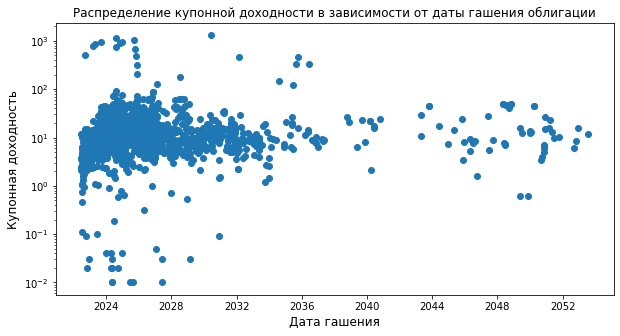

In [23]:
# визуализируем данные столбцов 'MATDATE', 'profit'

plt.figure(figsize=(10, 5))
plt.subplot()
plt.scatter(x=rub_bonds['MATDATE'], y=rub_bonds['profit'])
plt.yscale(value='log')
plt.title('Распределение купонной доходности в зависимости от даты гашения облигации')
plt.xlabel('Дата гашения', fontsize=12)
plt.ylabel('Купонная доходность', fontsize=12)
plt.savefig('rub_bonds.png', dpi=300, bbox_inches='tight')
plt.show()

# Из визуализации можно предположить, что оптимальное количество кластеров должно быть 3-4.

In [24]:
# Создадим упрощенный датафрейм для расчета кол-ва кластеров, удалим столбцы с типам datetime, object, с NaN-значениями

rub_bonds_df_short = rub_bonds.drop(columns=['COUPONFREQUENCY', 'SECID', 'SHORTNAME', 'NAME', 'FACEUNIT', 'EMITENTNAME', 'MATDATE', 'COUPONDATE', 'ISSUEDATE', 'current_date'], axis=1)

# А также удалим строки с NaN-значениям в столбцах 'DAYSTOREDEMPTION', 'years_to_redemption', так как речь идет о бессрочных облигациях
rub_bonds_df_short = rub_bonds_df_short.dropna(subset=['DAYSTOREDEMPTION', 'years_to_redemption', 'bond_term']) 

In [25]:
rub_bonds_df_short.isna().sum()

FACEVALUE                 0
ISSUESIZE                 0
IS_QUALIFIED_INVESTORS    0
HIGH_RISK                 0
COUPONPERCENT             0
COUPONVALUE               0
COUPONDAYSPASSED          0
COUPONDAYSREMAIN          0
COUPONLENGTH              0
DAYSTOREDEMPTION          0
INN                       0
PRICE                     0
PRICE_RUB                 0
bond_term                 0
years_to_redemption       0
NKD_RUB                   0
profit                    0
dtype: int64

In [26]:
# Повторяем алгоритм k-средних со значениями от k=2 до k=10 и вычисляем инерцию для каждого значения k в заданном диапазоне

inertias = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(rub_bonds_df_short)
    inertias.append(kmeans.inertia_)

In [27]:
inertias

[1.459695342302689e+21,
 5.647905731403717e+20,
 2.8875811946243686e+20,
 1.910057650983719e+20,
 1.0985775593731654e+20,
 6.4585085998968365e+19,
 4.397193728772771e+19,
 3.2139812156489855e+19]

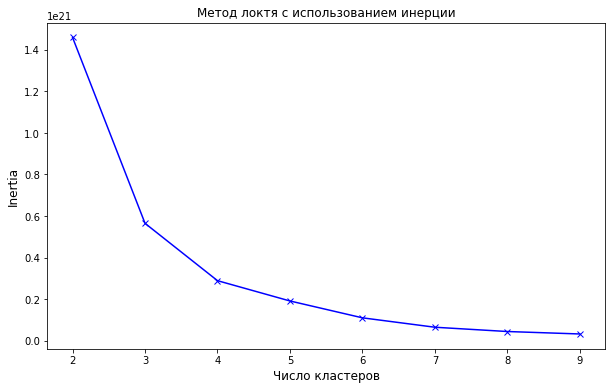

In [28]:
# Визуализация результатов

plt.figure(figsize =(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Число кластеров', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Метод локтя с использованием инерции', fontsize=12)
plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

# Чтобы определить оптимальное количество кластеров, мы должны выбрать значение k в «изгибе», то есть в точке, 
# после которой инерция начинает линейно уменьшаться. Таким образом, для заданных данных можно сделать вывод, 
# что оптимальное количество кластеров для данных - 3-4.

## PCA

In [29]:
# воспользуемся PCA для проецирования в двухмерное пространство и отображения данных и кластеров в этом новом пространстве

pca = PCA(2)

In [30]:
df_pca = pca.fit_transform(rub_bonds_df_short)

In [31]:
df_pca = pd.DataFrame(df_pca)

In [32]:
df_pca.columns = ['x1', 'x2']

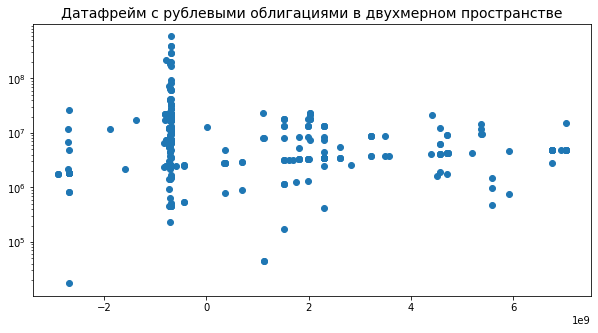

In [33]:
# отобразим на графике датафрейм, трансформированный в двухмерное пространство

plt.figure(figsize=(10, 5))
plt.scatter(df_pca.x1, df_pca.x2)
plt.yscale(value='log')
plt.title('Датафрейм с рублевыми облигациями в двухмерном пространстве', fontsize=14)
plt.savefig('PCA.png', dpi=300, bbox_inches='tight')

## Применение кластеризации KMeans

In [ ]:
# разобъем датафрейм на 3 и 4 кластера

In [34]:
kmeans = KMeans(n_clusters=3, random_state=123)
predict = kmeans.fit_predict(df_pca)
print(f'Silhouette Score(n=3): {silhouette_score(df_pca, predict)}')

Silhouette Score(n=3): 0.8557186499373057


C:\Users\anna_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Данные, разбитые на 3 кластера')

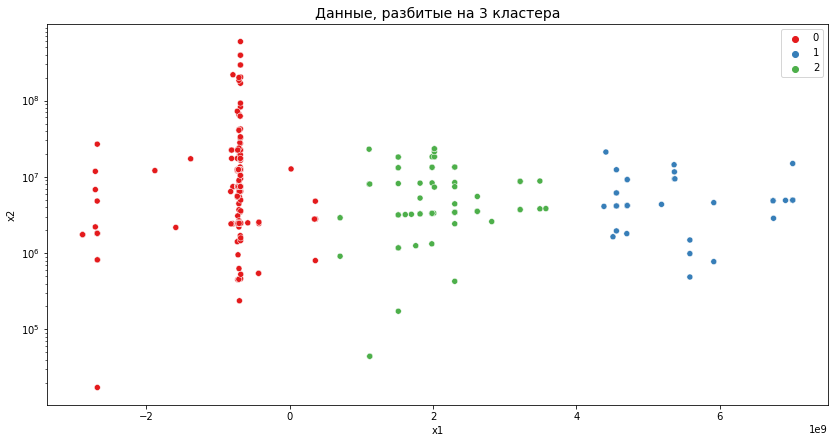

In [35]:
# Кластерные точки данных для значений k=3

plt.figure(figsize=(14, 7))
three_clusters = sns.scatterplot(df_pca['x1'], df_pca['x2'], hue=predict, palette='Set1')
three_clusters.set_yscale('log')
plt.title('Данные, разбитые на 3 кластера', fontsize=14)

In [36]:
kmeans = KMeans(n_clusters=4, random_state=123)
predict = kmeans.fit_predict(df_pca)
print(f'Silhouette Score(n=4): {silhouette_score(df_pca, predict)}')

Silhouette Score(n=4): 0.8852532190269876


C:\Users\anna_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


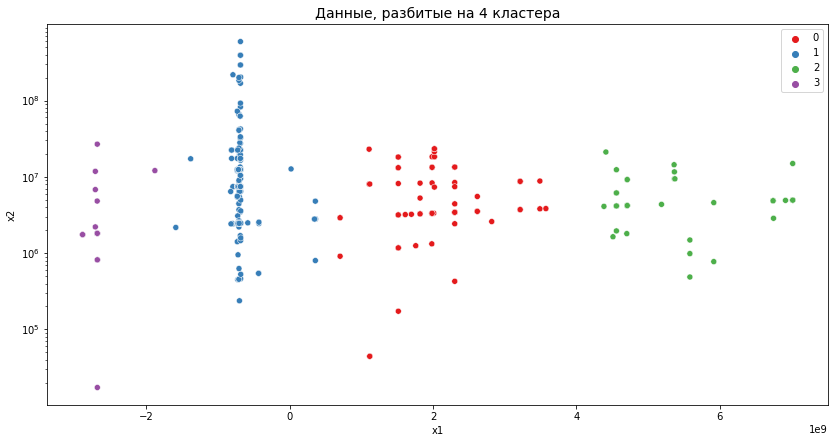

In [37]:
# Кластерные точки данных для значений k=4

plt.figure(figsize=(14, 7))
four_clusters = sns.scatterplot(df_pca['x1'], df_pca['x2'], hue=predict, palette='Set1')
four_clusters.set_yscale('log')
plt.title('Данные, разбитые на 4 кластера', fontsize=14)
plt.savefig('four_clusters.png', dpi=300, bbox_inches='tight')

In [55]:
# По результатам проведения анализа кластеризации методом локтя, оценкой силуэта и визуализации данных можно сказать, что 
# оптимальным количеством кластеров является 4, так как коэффициент силуэта выше (0,89), чем при разбиении на 3 кластера (0,86).
# На результаты кластеризации повлияли доходность облигаций, ставка купона, срок выплаты купона, номинальная стоимость, объем
# выпуска, цена облигаций, срок до гашения бумаги, рискованность бумаги (высокий риск или нет), а также наличие статуса 
# квалифицированного инвестора. Столбец 'ИНН' оказывает влияние на результат моделирования. Данный параметр не влияет напрямую
# на доходность бумаги и ее рискованность на понятийном уровне. Однако есть закономерность, которая, возможно, связана с тем,
# что в реальности по ИНН могут выделяться эмитенты (например, доля бумаг, эмитированных Сбером и ВТБ, вместе достигает 28% от
# общей выборки) или регионы/инспекции, где зарегистрированы рисковые эмитенты, поэтому можно сказать, что 'ИНН' может влиять 
# на результаты кластеризации.
# По оси Y отражается объем выпуска ценных бумаг, а по оси Х - доходность, однако стоит учитывать, что данные из 17 столбцов
# упрощенного датафрейма были сжаты до двухмерного пространства.
# Интерпретируя группы кластеров, можно предположить, что кластер 3 (фиолетовый) - это облигации с отрицательной доходностью.
# Кластер 1 (синий) - это в основном облигации номиналом 1000 руб. (всего 1737 бумаг данного номинала в выборке) и широким 
# диапазоном объемов выпуска (от 5 млн шт. до 15 млн шт.), доходность облигаций в данном кластере невысокая.
# Кластер 0 (красный) - среднесрочные облигации с умеренной доходностью.
# Кластер 2 (зеленый) является долгосрочными высокодоходными бумагами, но, скорее всего, и самыми рискованными.

##### 2. По низкорисковым рублевым облигациям с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигациям, выпущенных в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей даты. (график и/или таблица). 

In [38]:
# Отбираем низкорисковые рублевые облигации с датой промежуточной выплаты по купонам не более 20% 

rub_bonds['NKD_period_less_20'] = (rub_bonds['COUPONDAYSPASSED'] / rub_bonds['COUPONLENGTH']).round(2)
low_risk_bonds = rub_bonds.query('HIGH_RISK == 0 & NKD_period_less_20 <= 0.2')

### Расчет НКД

In [39]:
# умножаем период расчета <= 0.2 на ставку купона, поделенную на число купонов в год. Тем самым получим ставку купона, 
# заработанную за период расчета не более 20%

low_risk_bonds['NKD_period_coupon'] = low_risk_bonds['NKD_period_less_20'] * low_risk_bonds['COUPONPERCENT'] / low_risk_bonds['COUPONFREQUENCY']

C:\Users\anna_\AppData\Local\Temp/ipykernel_16768/167421286.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk_bonds['NKD_period_coupon'] = low_risk_bonds['NKD_period_less_20'] * low_risk_bonds['COUPONPERCENT'] / low_risk_bonds['COUPONFREQUENCY']


In [40]:
# Для расчета НКД в рублях умножаем на номинальную стоимость облигации и делим на 100%.

low_risk_bonds['NKD_period_less_20_RUB'] = (low_risk_bonds['NKD_period_coupon'] / 100 * low_risk_bonds['FACEVALUE']).round(2)

C:\Users\anna_\AppData\Local\Temp/ipykernel_16768/3642636183.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk_bonds['NKD_period_less_20_RUB'] = (low_risk_bonds['NKD_period_coupon'] / 100 * low_risk_bonds['FACEVALUE']).round(2)


### Расчет доходности

In [41]:
# цена покупки
price = low_risk_bonds['PRICE'] * low_risk_bonds['FACEVALUE'] / 100

# купонный доход, руб.
KD = low_risk_bonds['FACEVALUE'] * low_risk_bonds['COUPONPERCENT'] / 100

In [42]:
# Доходность низкоризковых рублевых облигаций за год, в %

low_risk_bonds['NKD_period_less_20_profit'] = ((low_risk_bonds['FACEVALUE'] - price).apply(lambda x: x if x <= 0 else x * NDFL) - low_risk_bonds['NKD_period_less_20_RUB'] + NDFL * KD * years) * 100 / \
                                            ((price + low_risk_bonds['NKD_period_less_20_RUB']) * (1 + broker_commission + moex_commission))
low_risk_bonds['NKD_period_less_20_profit'] = low_risk_bonds['NKD_period_less_20_profit'].round(2)

C:\Users\anna_\AppData\Local\Temp/ipykernel_16768/314770322.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk_bonds['NKD_period_less_20_profit'] = ((low_risk_bonds['FACEVALUE'] - price).apply(lambda x: x if x <= 0 else x * NDFL) - low_risk_bonds['NKD_period_less_20_RUB'] + NDFL * KD * years) * 100 / \
C:\Users\anna_\AppData\Local\Temp/ipykernel_16768/314770322.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk_bonds['NKD_period_less_20_profit'] = low_risk_bonds['NKD_period_less_20_profi

In [43]:
low_risk_bonds.head()

,SECID,SHORTNAME,NAME,FACEVALUE,FACEUNIT,ISSUESIZE,MATDATE,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,...,PRICE_RUB,current_date,bond_term,years_to_redemption,NKD_RUB,profit,NKD_period_less_20,NKD_period_coupon,NKD_period_less_20_RUB,NKD_period_less_20_profit
15,RU000A0JQAL8,ДОМ.РФ14об,ДОМ.РФ (АО) обл. сер. А14,1000,RUB,7000000,2023-05-15,0,0,2,...,1047.71,2022-06-16,13.71,0.91,14.01,9.14,0.17,1.4025,14.02,9.14
20,RU000A0JRJB8,ЗСД 01,Запад.скор.диаметр АО об.01,1000,RUB,5000000,2031-05-13,0,0,2,...,1229.89,2022-06-16,19.93,8.91,6.29,-11.30,0.12,0.6264,6.26,-11.3
21,RU000A0JRJL7,ЗСД 02,Запад.скор.диаметр АО об.02,1000,RUB,5000000,2031-05-13,0,0,2,...,1032.99,2022-06-16,19.93,8.91,6.29,5.60,0.12,0.6264,6.26,5.6
64,RU000A0JTY57,РЖД БО-18,"""Российские ЖД"" ОАО БО-18",1000,RUB,25000000,2043-04-29,0,0,2,...,879.28,2022-06-16,29.90,20.87,10.18,29.28,0.12,1.0614,10.61,29.21
65,RU000A0JTYJ6,ФСК ЕЭС-23,"""ФСК ЕЭС""(ПАО)-обл. сер.23",1000,RUB,10000000,2048-04-27,0,0,4,...,753.05,2022-06-16,34.88,25.87,8.25,50.11,0.18,0.84735,8.47,50.06


In [44]:
low_risk_bonds.isna().sum()

SECID                         0
SHORTNAME                     0
NAME                          0
FACEVALUE                     0
FACEUNIT                      0
ISSUESIZE                     0
MATDATE                       3
IS_QUALIFIED_INVESTORS        0
HIGH_RISK                     0
COUPONFREQUENCY              59
COUPONDATE                    0
COUPONPERCENT                 0
COUPONVALUE                   0
COUPONDAYSPASSED              0
COUPONDAYSREMAIN              0
COUPONLENGTH                  0
ISSUEDATE                     0
DAYSTOREDEMPTION              3
EMITENTNAME                   0
INN                           0
PRICE                         0
PRICE_RUB                     0
current_date                  0
bond_term                     3
years_to_redemption           3
NKD_RUB                       0
profit                        0
NKD_period_less_20            0
NKD_period_coupon            59
NKD_period_less_20_RUB       59
NKD_period_less_20_profit    59
dtype: i

In [45]:
# Теперь удалим строки с NaN-значениями по облигациям бессрочным и у которых нет выплат по купонам.

low_risk_bonds = low_risk_bonds.dropna(subset=['COUPONFREQUENCY', 'MATDATE'])
low_risk_bonds.isna().sum()

SECID                        0
SHORTNAME                    0
NAME                         0
FACEVALUE                    0
FACEUNIT                     0
ISSUESIZE                    0
MATDATE                      0
IS_QUALIFIED_INVESTORS       0
HIGH_RISK                    0
COUPONFREQUENCY              0
COUPONDATE                   0
COUPONPERCENT                0
COUPONVALUE                  0
COUPONDAYSPASSED             0
COUPONDAYSREMAIN             0
COUPONLENGTH                 0
ISSUEDATE                    0
DAYSTOREDEMPTION             0
EMITENTNAME                  0
INN                          0
PRICE                        0
PRICE_RUB                    0
current_date                 0
bond_term                    0
years_to_redemption          0
NKD_RUB                      0
profit                       0
NKD_period_less_20           0
NKD_period_coupon            0
NKD_period_less_20_RUB       0
NKD_period_less_20_profit    0
dtype: int64

In [ ]:
# Затем необходимо добавить ограничение по купонной доходности оставшихся бумаг. На текущую дату ключевая ставка ЦБ - 9.5%,
# ставка процентов по вкладам сроком на 1 год составляет примерно 7%, инфляция - 15%. Поэтому предлагается ограничить доходность
# в интервале от 7% до 15%.

In [46]:
# Отбираем низкорисковые рублевые облигации с доходностью от 7 до 15%

lower_limit = 7
upper_limit = 15

low_risk_bonds = low_risk_bonds[low_risk_bonds['NKD_period_less_20_profit'].between(lower_limit, upper_limit)]
low_risk_bonds

,SECID,SHORTNAME,NAME,FACEVALUE,FACEUNIT,ISSUESIZE,MATDATE,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,...,PRICE_RUB,current_date,bond_term,years_to_redemption,NKD_RUB,profit,NKD_period_less_20,NKD_period_coupon,NKD_period_less_20_RUB,NKD_period_less_20_profit
15,RU000A0JQAL8,ДОМ.РФ14об,ДОМ.РФ (АО) обл. сер. А14,1000,RUB,7000000,2023-05-15,0,0,2,...,1047.71,2022-06-16,13.71,0.91,14.01,9.14,0.17,1.4025,14.02,9.14
67,RU000A0JTYL2,Роснефть06,ПАО НК Роснефть обл.06,1000,RUB,10000000,2023-05-30,0,0,2,...,979.98,2022-06-16,9.97,0.95,2.88,7.95,0.08,0.28,2.8,7.96
68,RU000A0JTYM0,Роснефть09,ПАО НК Роснефть обл.09,1000,RUB,15000000,2023-05-30,0,0,2,...,972.18,2022-06-16,9.97,0.95,2.88,8.71,0.08,0.28,2.8,8.72
69,RU000A0JTYN8,Роснефть10,ПАО НК Роснефть обл.10,1000,RUB,15000000,2023-05-30,0,0,2,...,972.68,2022-06-16,9.97,0.95,2.88,8.66,0.08,0.28,2.8,8.67
91,RU000A0JUA45,ИРКУТ БО-4,"Корпорация ""ИРКУТ"" ПАО БО-04",1000,RUB,5000000,2023-11-06,0,0,2,...,983.82,2022-06-16,9.97,1.39,9.12,9.26,0.20,0.9,9.0,9.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,RU000A104U68,ИНГРАД 2P3,ИНГРАД 002P-03,1000,RUB,10000000,2032-05-14,0,0,2,...,1007.97,2022-06-16,9.97,9.91,7.97,12.41,0.10,0.7655,7.66,12.45
2228,RU000A104UA4,Сегежа2P4R,ГК Сегежа 002P-04R,1000,RUB,8200000,2037-05-11,0,0,4,...,1007.32,2022-06-16,14.95,14.90,4.82,8.77,0.18,0.495,4.95,8.75
2233,RU000A104UV0,ИАДОМ 1P18,ДОМ.РФ Ипотечный агент БО 1P18,1000,RUB,6183696,2032-05-28,1,0,12,...,1003.95,2022-06-16,9.99,9.95,3.75,9.48,0.14,0.133,1.33,9.74
2238,RU000A104VA2,РедСофт2P3,Ред Софт БО 002Р-03,1000,RUB,100000,2024-12-04,0,0,4,...,1077.84,2022-06-16,2.49,2.47,3.64,8.11,0.08,0.38,3.8,8.09


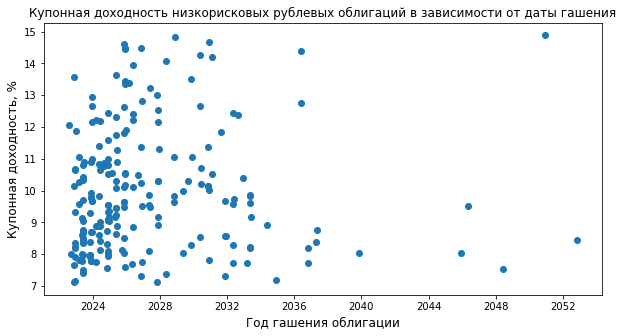

In [47]:
plt.figure(figsize=(10, 5))
plt.subplot()
plt.scatter(x=low_risk_bonds['MATDATE'], y=low_risk_bonds['NKD_period_less_20_profit'])
plt.title('Купонная доходность низкорисковых рублевых облигаций в зависимости от даты гашения')
plt.xlabel('Год гашения облигации', fontsize=12)
plt.ylabel('Купонная доходность, %', fontsize=12)
plt.savefig('low_risk_bonds.png', dpi=300, bbox_inches='tight')
plt.show()